In [1]:
from mnist_web import mnist
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#download the dataset using mnist_web
x_train, y_train, x_test, y_test = mnist(path='./data')

In [3]:
#check the format and shape of x_train, x_test
print('The type of x_train  : ', x_train.dtype)
print('The type of x_test   : ', x_test.dtype)

print('The shape of X_train : ', x_train.shape)
print('The shape of X_test  : ', x_test.shape)

The type of x_train  :  float32
The type of x_test   :  float32
The shape of X_train :  (60000, 784)
The shape of X_test  :  (10000, 784)


### Least Squares Classifier

In [4]:
#Change the format of X_train， X_test, y_train, y_test
def process_data(X, y):
    X_Data = [[] for i in range(10)]
    Y_Data = [[] for i in range(10)]

    for i in range(len(X)):
        item_x = X[i, :]
        item_y = np.where(y[i, :] == True)[0][0]
        X_Data[item_y].append(item_x)
        Y_Data[item_y].append(1)

    for i in range(10):
        X_Data[i] = np.array(X_Data[i])
        Y_Data[i] = np.array(Y_Data[i])

    return X_Data, Y_Data

In [5]:
### Binary Classifier (Least Square)
def SquareLeast(X, y):
    
    X_1 = np.concatenate([X, np.ones(shape=(X.shape[0], 1))], axis=1)
    XTX = X_1.T@X_1
    if np.linalg.matrix_rank(XTX) == XTX.shape[0]:
        XTX_inv = np.linalg.inv(XTX)
    else:
        # U, Sigma, V = np.linalg.svd(XTX)
        # XTX_inv = V.T@np.linalg.inv(np.diag(Sigma))@U.T
        XTX_inv = np.linalg.pinv(XTX)
    beta = XTX_inv@X_1.T@y
    
    Beta = beta[0:-1]
    Alpha = beta[-1]

    return Beta, Alpha 

In [6]:
### One-vs-One Multi-Classifier
def Multi_Classifier_One_vs_One(X, y):
    
    beta  = np.zeros(shape=(10, 10, X.shape[1]))
    alpha = np.zeros(shape=(10, 10, 1))
    
    X_train, Y_train = process_data(X, y)

    for i in range(0, 10):
        for j in range(i+1, 10):
            X_Temp = np.concatenate([X_train[i], X_train[j]], axis=0)
            Y_Temp = np.concatenate([Y_train[i], (-1)*Y_train[j]], axis=0)
            beta_temp, alpha_temp = SquareLeast(X_Temp, Y_Temp)
            beta[i, j] = beta_temp
            alpha[i, j] = alpha_temp

    return beta, alpha

In [7]:
### One-vs-All Multi-Classifier
def Multi_Classifier_One_vs_All(X, y):

    beta  = np.zeros(shape=(10, X.shape[1]))
    alpha = np.zeros(shape=(10, 1))
    
    X_train, Y_train = process_data(X, y)

    for i in range(10):
        X_Temp = X_train[i]
        Y_Temp = Y_train[i]
        for j in range(10):
            if j == i : continue
            X_Temp = np.concatenate([X_Temp, X_train[j]], axis=0)
            Y_Temp = np.concatenate([Y_Temp, (-1)*Y_train[j]], axis=0)
        beta_temp, alpha_temp = SquareLeast(X_Temp, Y_Temp)
        beta[i] = beta_temp
        alpha[i] = alpha_temp

    return beta, alpha

In [8]:
### Evaluate the error of one-vs-one calssifier using error rate and confusion matrix
def Train(X, y, Method):
    if Method.__name__ == 'Multi_Classifier_One_vs_One':
        Beta, Alpha = Multi_Classifier_One_vs_One(X, y)
    else:
        Beta, Alpha = Multi_Classifier_One_vs_All(X, y)
    return Beta, Alpha

def Evaluate(X, y, Method, Beta, Alpha, ERROR_RATE=True, CONFUSION_MATRIX=True):
    Correct = 0
    Confusion_matrix = np.zeros(shape=(10, 10))
    Beta, Alpha = Beta, Alpha
    
    if Method.__name__ == 'Multi_Classifier_One_vs_One':
        for k in range(X.shape[0]):
            Vote = np.zeros(10)
            Features = X[k, :]
            for i in range(10):
                for j in range(i+1, 10):
                    beta, alpha = Beta[i, j], Alpha[i, j]
                    y_pre = Features@beta + alpha
                    if y_pre >= 0 : Vote[i] += 1
                    else          : Vote[j] += 1
            
            y_real = np.where(y[k] == True)[0][0]
            y_pre  = np.argmax(Vote)
            Confusion_matrix[y_real][y_pre] += 1
            if y_pre == y_real : Correct += 1
    
    else:
        for k in range(X.shape[0]):
            Vote = np.zeros(10)
            Features = X[k, :]
            for i in range(10):
                beta, alpha = Beta[i], Alpha[i]
                Vote[i] = Features@beta + alpha
            y_real = np.where(y[k] == True)[0][0]
            y_pre = np.argmax(Vote)
            Confusion_matrix[y_real][y_pre] += 1
            if y_pre == y_real : Correct += 1
    
    error_rate = 1 - Correct/len(y)

    if ERROR_RATE and CONFUSION_MATRIX : return (error_rate, Confusion_matrix)
    elif ERROR_RATE : return error_rate
    else : return Confusion_matrix.astype(np.int64)

In [9]:
### Evaluate the training error of one-vs-one and one-vs-all classifier
# train Image

Beta_One_vs_One, Alpha_One_vs_One = Train(x_train, y_train, Method=Multi_Classifier_One_vs_One)
Error_Rate, Confusion_Matrix = Evaluate(x_train, y_train, Multi_Classifier_One_vs_One, Beta_One_vs_One, Alpha_One_vs_One)
print(f'The error rate of one vs one classifier on train image is : {Error_Rate:.4f}')
print('The confusion matrix of one vs one classifier is \n', Confusion_Matrix.astype(np.int64))

print('-'*96)

Beta_One_vs_All, Alpha_One_vs_All = Train(x_train, y_train, Method=Multi_Classifier_One_vs_All)
Error_Rate, Confusion_Matrix = Evaluate(x_train, y_train, Multi_Classifier_One_vs_All, Beta_One_vs_All, Alpha_One_vs_All)
print(f'The error rate of one vs all classifier on train image is : {Error_Rate:.4f}')
print('The confusion matrix of one vs all classifier is \n', Confusion_Matrix.astype(np.int64))

The error rate of one vs one classifier on train image is : 0.0622
The confusion matrix of one vs one classifier is 
 [[5806    3   15    8   11   19   22    6   32    1]
 [   2 6623   36   17    7   16    2   11   21    7]
 [  51   68 5522   49   57   20   42   44   92   13]
 [  26   42  119 5580    9  160   18   48   90   39]
 [  14   18   20    5 5586   11   14   16    8  150]
 [  44   48   39  138   22 4968   93   10   46   13]
 [  27   16   36    2   32   84 5690    0   30    1]
 [  10   76   53    7   69    9    0 5881    5  155]
 [  35  195   42  107   48  142   37   25 5155   65]
 [  22   14   17   82  155   30    3  137   31 5458]]
------------------------------------------------------------------------------------------------
The error rate of one vs all classifier on train image is : 0.1423
The confusion matrix of one vs all classifier is 
 [[5682    7   18   14   24   43   64    4   61    6]
 [   2 6548   40   15   19   31   14   12   55    6]
 [  99  264 4792  149  108   1

In [10]:
### Evaluate the training error of one-vs-one and one-vs-all classifier
# test Image

Error_Rate, Confusion_Matrix = Evaluate(x_test, y_test, Multi_Classifier_One_vs_One, Beta_One_vs_One, Alpha_One_vs_One)
print(f'The error rate of one vs one classifier on test image is : {Error_Rate:.4f}')
print('The confusion matrix of one vs one classifier is \n', Confusion_Matrix.astype(np.int64))
for i in range(10):
    Right = Confusion_Matrix[i, i]
    Count = Confusion_Matrix[i, :].sum()
    Accuracy = Right/Count
    print(f'The Predict Accuracy of number {i} is {Accuracy:.4f}')

print('-'*96)

Error_Rate, Confusion_Matrix = Evaluate(x_test, y_test, Multi_Classifier_One_vs_All, Beta_One_vs_All, Alpha_One_vs_All)
print(f'The error rate of one vs one classifier on test image is : {Error_Rate:.4f}')
print('The confusion matrix of one vs one classifier is \n', Confusion_Matrix.astype(np.int64))
for i in range(10):
    Right = Confusion_Matrix[i, i]
    Count = Confusion_Matrix[i, :].sum()
    Accuracy = Right/Count
    print(f'The Predict Accuracy of number {i} is {Accuracy:.4f}')

The error rate of one vs one classifier on test image is : 0.0703
The confusion matrix of one vs one classifier is 
 [[ 961    0    1    1    0    6    8    3    0    0]
 [   0 1120    3    3    1    1    4    1    2    0]
 [   9   18  936   12   10    5   10   10   22    0]
 [   9    1   18  926    2   20    1    7   21    5]
 [   2    4    6    1  931    1    7    4    3   23]
 [   7    5    3   30    8  800   17    2   15    5]
 [   6    5   12    0    5   19  908    1    2    0]
 [   1   16   17    3   11    1    0  955    1   23]
 [   7   17    8   23   10   36   10   10  840   13]
 [   6    5    1   11   30   12    0   21    3  920]]
The Predict Accuracy of number 0 is 0.9806
The Predict Accuracy of number 1 is 0.9868
The Predict Accuracy of number 2 is 0.9070
The Predict Accuracy of number 3 is 0.9168
The Predict Accuracy of number 4 is 0.9481
The Predict Accuracy of number 5 is 0.8969
The Predict Accuracy of number 6 is 0.9478
The Predict Accuracy of number 7 is 0.9290
The Pred

### Randomized Feature Based Least Square Classifiers

In [11]:
### feature map

L = 1000
W = np.random.normal(size=(x_train.shape[1]+1, L))

def process_data_H(X, y, W):
    X_Data = X@W[0:-1] + W[-1]
    Y_Data = y
    return X_Data, Y_Data

In [12]:
### feature map with nonlinear function
def Identity_Function(x):
    return x

def Sigmoid_Function(x):
    return 1/(1 + np.exp(-x))

def Sinusoidal_Function(x):
    return np.sin(x)

def ReLU_function(x):
    x = 1*(x>0)*x
    return x

def process_data_H_G(X, y, W, G):
    X_Data = X@W[0:-1] + W[-1]
    X_Data = G(X_Data)
    Y_Data = y
    return X_Data, Y_Data

In [13]:
### Compare the classification performance for different choices of the feature mapping by changing the non-linearity. 

NonLinearFunc = [Identity_Function, Sigmoid_Function, Sinusoidal_Function, ReLU_function]

In [14]:
### Performance of different function using one vs one classifier

for G in NonLinearFunc:
    X_G, Y_G = process_data_H_G(x_train, y_train, W, G)
    X_test_G, Y_test_G = process_data_H_G(x_test, y_test, W, G)

    Beta_One_vs_One, Alpha_One_vs_One = Train(X_G, Y_G, Method=Multi_Classifier_One_vs_One)

    Error_Rate, Confusion_Matrix = Evaluate(X_G, Y_G, Multi_Classifier_One_vs_One, Beta_One_vs_One, Alpha_One_vs_One)
    Error_Rate_test, Confusion_Matrix_test = Evaluate(X_test_G, Y_test_G, Multi_Classifier_One_vs_One, Beta_One_vs_One, Alpha_One_vs_One)

    print(f'The error rate of one vs one classifier with {G.__name__} on train image is : {Error_Rate:.4f}')
    print(f'The error rate of one vs one classifier with {G.__name__} on test image is : {Error_Rate_test:.4f}')

The error rate of one vs one classifier with Identity_Function on train image is : 0.0620
The error rate of one vs one classifier with Identity_Function on test image is : 0.0702
The error rate of one vs one classifier with Sigmoid_Function on train image is : 0.0292
The error rate of one vs one classifier with Sigmoid_Function on test image is : 0.0424
The error rate of one vs one classifier with Sinusoidal_Function on train image is : 0.7889
The error rate of one vs one classifier with Sinusoidal_Function on test image is : 0.8635
The error rate of one vs one classifier with ReLU_function on train image is : 0.0218
The error rate of one vs one classifier with ReLU_function on test image is : 0.0333


In [15]:
### Performance of different function using one vs all classifier

for G in NonLinearFunc:
    X_G, Y_G = process_data_H_G(x_train, y_train, W, G)
    X_test_G, Y_test_G = process_data_H_G(x_test, y_test, W, G)

    Beta_One_vs_All, Alpha_One_vs_All = Train(X_G, Y_G, Method=Multi_Classifier_One_vs_All)
    
    Error_Rate, Confusion_Matrix = Evaluate(X_G, Y_G, Multi_Classifier_One_vs_All, Beta_One_vs_All, Alpha_One_vs_All)
    Error_Rate_test, Confusion_Matrix_test = Evaluate(X_test_G, Y_test_G, Multi_Classifier_One_vs_All, Beta_One_vs_All, Alpha_One_vs_All)
    print(f'The error rate of one vs all classifier with {G.__name__} on train image is : {Error_Rate:.4f}')
    print(f'The error rate of one vs all classifier with {G.__name__} on test image is : {Error_Rate_test:.4f}')

The error rate of one vs all classifier with Identity_Function on train image is : 0.1423
The error rate of one vs all classifier with Identity_Function on test image is : 0.1397
The error rate of one vs all classifier with Sigmoid_Function on train image is : 0.0664
The error rate of one vs all classifier with Sigmoid_Function on test image is : 0.0684
The error rate of one vs all classifier with Sinusoidal_Function on train image is : 0.7993
The error rate of one vs all classifier with Sinusoidal_Function on test image is : 0.8604
The error rate of one vs all classifier with ReLU_function on train image is : 0.0549
The error rate of one vs all classifier with ReLU_function on test image is : 0.0560


In [16]:
### Vary the number of features L, and plot the average error rate as a function of the number of features L.
# in this problem, i use the Identity Function with one vs all classifier to plot the average error rate of test image

ErrorRate = []

for L in range(100, 1600, 100):
    W = np.random.normal(size=(x_train.shape[1]+1, L))
    X_G, Y_G = process_data_H_G(x_train, y_train, W, Identity_Function)
    X_test_G, Y_test_G = process_data_H_G(x_test, y_test, W, Identity_Function)
    Beta_One_vs_All, Alpha_One_vs_All = Train(X_G, Y_G, Method=Multi_Classifier_One_vs_All)
    Error_Rate_test, Confusion_Matrix_test = Evaluate(X_test_G, Y_test_G, Multi_Classifier_One_vs_All, Beta_One_vs_All, Alpha_One_vs_All)
    print(f'The error rate of one vs all classifier with the numbers of features {L} on test image is : {Error_Rate_test:.4f}')
    ErrorRate.append(Error_Rate_test)

The error rate of one vs all classifier with the numbers of features 100 on test image is : 0.1664
The error rate of one vs all classifier with the numbers of features 200 on test image is : 0.1444
The error rate of one vs all classifier with the numbers of features 300 on test image is : 0.1401
The error rate of one vs all classifier with the numbers of features 400 on test image is : 0.1392
The error rate of one vs all classifier with the numbers of features 500 on test image is : 0.1409
The error rate of one vs all classifier with the numbers of features 600 on test image is : 0.1397
The error rate of one vs all classifier with the numbers of features 700 on test image is : 0.1398
The error rate of one vs all classifier with the numbers of features 800 on test image is : 0.1397
The error rate of one vs all classifier with the numbers of features 900 on test image is : 0.1397
The error rate of one vs all classifier with the numbers of features 1000 on test image is : 0.1397
The error

Text(0.5, 1.0, 'Error rate of different numbers of features')

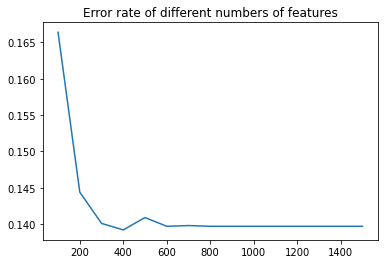

In [17]:
L = np.array(range(100, 1600, 100))
Error = np.array(ErrorRate)

plt.plot(L, Error)
plt.title('Error rate of different numbers of features')

In [18]:
### Compare the error rate for different noise levels ϵ and determine the point where the classifier breaks down.
E = [1e-8*10**i for i in range(8)]
E += [0.1*i for i in range(2, 10)]

ErrorRate = []
L = 300
W = np.random.normal(size=(x_train.shape[1]+1, L))
X_G, Y_G = process_data_H_G(x_train, y_train, W, Identity_Function)
Beta_One_vs_All, Alpha_One_vs_All = Train(X_G, Y_G, Method=Multi_Classifier_One_vs_All)

for e in E:
    X_test_G, Y_test_G = process_data_H_G(x_test+np.random.normal(size=x_test.shape, loc=0, scale=e), y_test, W, Identity_Function)
    Error_Rate_test, Confusion_Matrix_test = Evaluate(X_test_G, Y_test_G, Multi_Classifier_One_vs_All, Beta_One_vs_All, Alpha_One_vs_All)
    ErrorRate.append(Error_Rate_test)
    print(f'The error rate of one vs all classifier with the different noise levels {e} on test image is : {Error_Rate_test:.4f}')

The error rate of one vs all classifier with the different noise levels 1e-08 on test image is : 0.1387
The error rate of one vs all classifier with the different noise levels 1e-07 on test image is : 0.1387
The error rate of one vs all classifier with the different noise levels 1e-06 on test image is : 0.1387
The error rate of one vs all classifier with the different noise levels 1e-05 on test image is : 0.1386
The error rate of one vs all classifier with the different noise levels 0.0001 on test image is : 0.1387
The error rate of one vs all classifier with the different noise levels 0.001 on test image is : 0.1386
The error rate of one vs all classifier with the different noise levels 0.01 on test image is : 0.1384
The error rate of one vs all classifier with the different noise levels 0.1 on test image is : 0.1750
The error rate of one vs all classifier with the different noise levels 0.2 on test image is : 0.2745
The error rate of one vs all classifier with the different noise lev

Text(0.5, 1.0, 'Error rate of different nosie level')

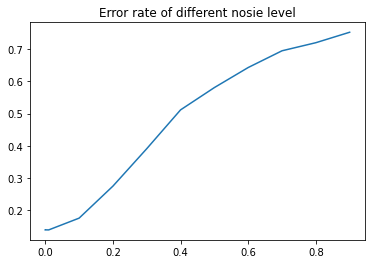

In [19]:
### For a fixed test data point, plot the output of the classifier

E = np.array(E)
Error = np.array(ErrorRate)

plt.plot(E, Error)
plt.title('Error rate of different nosie level')

In [20]:
### uniform distribution used to generate the matrix W and b
L = 1000
W = np.random.uniform(size=(x_train.shape[1]+1, L))

NonLinearFunc = [Identity_Function, Sigmoid_Function, Sinusoidal_Function, ReLU_function]

### Performance of different function using one vs one and one vs all classifier

for G in NonLinearFunc:
    X_G, Y_G = process_data_H_G(x_train, y_train, W, G)
    X_test_G, Y_test_G = process_data_H_G(x_test, y_test, W, G)

    Beta_One_vs_One, Alpha_One_vs_One = Train(X_G, Y_G, Method=Multi_Classifier_One_vs_One)

    Error_Rate, Confusion_Matrix = Evaluate(X_G, Y_G, Multi_Classifier_One_vs_One, Beta_One_vs_One, Alpha_One_vs_One)
    Error_Rate_test, Confusion_Matrix_test = Evaluate(X_test_G, Y_test_G, Multi_Classifier_One_vs_One, Beta_One_vs_One, Alpha_One_vs_One)

    print(f'The error rate of one vs one classifier with {G.__name__} and uniform distribution on train image is : {Error_Rate:.4f}')
    print(f'The error rate of one vs one classifier with {G.__name__} on test image is : {Error_Rate_test:.4f}')

    Beta_One_vs_All, Alpha_One_vs_All = Train(X_G, Y_G, Method=Multi_Classifier_One_vs_All)    
    Error_Rate, Confusion_Matrix = Evaluate(X_G, Y_G, Multi_Classifier_One_vs_All, Beta_One_vs_All, Alpha_One_vs_All)
    Error_Rate_test, Confusion_Matrix_test = Evaluate(X_test_G, Y_test_G, Multi_Classifier_One_vs_All, Beta_One_vs_All, Alpha_One_vs_All)
    print(f'The error rate of one vs all classifier with {G.__name__} and uniform distribution on train image is : {Error_Rate:.4f}')
    print(f'The error rate of one vs all classifier with {G.__name__} on test image is : {Error_Rate_test:.4f}')

The error rate of one vs one classifier with Identity_Function and uniform distribution on train image is : 0.0619
The error rate of one vs one classifier with Identity_Function on test image is : 0.0702
The error rate of one vs all classifier with Identity_Function and uniform distribution on train image is : 0.1423
The error rate of one vs all classifier with Identity_Function on test image is : 0.1397
The error rate of one vs one classifier with Sigmoid_Function and uniform distribution on train image is : 0.8876
The error rate of one vs one classifier with Sigmoid_Function on test image is : 0.8865
The error rate of one vs all classifier with Sigmoid_Function and uniform distribution on train image is : 0.8877
The error rate of one vs all classifier with Sigmoid_Function on test image is : 0.8867
The error rate of one vs one classifier with Sinusoidal_Function and uniform distribution on train image is : 0.7709
The error rate of one vs one classifier with Sinusoidal_Function on tes